# ACRA results analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline
from matplotlib.font_manager import FontProperties

In this document, we generate the relevant metrics for each experiment. In particular, we use as relevant metrics the accuracy, the average utility gain, FPR and FNR.

##  Auxiliar functions

We define here the relevant metrics to be calculated for each experiment.

In [2]:
def postolabel(posterior, ut):
    aux = np.dot(ut, posterior.transpose())   
    return(np.argmax(aux, axis = 0))

In [3]:
def avgUt(y_true, y_pred, ut):
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    return( float(sum(ut[y_pred,y_true])) / float(len(y_true) ))

In [4]:
def acc(y_true, y_pred):
    return(accuracy_score(y_true, y_pred))

In [5]:
def FPR(y_true, y_pred):
    a = confusion_matrix(y_true, y_pred)
    return(float(a[0,1]) / float(sum(a[0,:])))

In [6]:
def FNR(y_true, y_pred):
    a = confusion_matrix(y_true, y_pred)
    return(float(a[1,0])/ float(sum((a[1,:]))))

## Results dataframe generation

For a given `N` and give `var`, this function reads the corresponding experiment, computes all relevant metrics, and returns a dataframe with the results.

In [7]:
dataPath = "results/"
dat = pd.read_csv(dataPath + "100AcraBigExp.csv")

In [8]:
def getMetrics(df, N, var):


    ut01 = [0, -2, -5, -10]
    columns = ["N", "var", "Ut01", "NBC_Acc", "ACRA_Acc", "NB_Acc", "NBC_AvgUt", "ACRA_AvgUt", "NB_AvgUt",\
               "NBC_FPR", "ACRA_FPR", "NB_FPR", "NBC_FNR", "ACRA_FNR", "NB_FNR"]
    resultsdf = pd.DataFrame(data=None, columns=columns)
    data = df[(df.N == N) & (df["var"] == var)]

    for i in range(len(ut01)):

        if ut01[i] == 0:
            ut = np.array([[1,0],[0,1]])
            NB_label = postolabel(data[["NBpost0", "NBpost1"]].values, ut)
            NBC_label = postolabel(data[["NBCpost0", "NBCpost1"]].values, ut)
            ACRA_label = postolabel(data[["ACRApost0", "ACRApost1"]].values, ut)

            resultsdf.loc[i] = [N, var, ut01[i], acc(data.spam.values, NBC_label), acc(data.spam.values, ACRA_label), \
                          acc(data.spam.values, NB_label), avgUt(data.spam.values, NBC_label, ut), \
                          avgUt(data.spam.values, ACRA_label, ut), avgUt(data.spam.values, NB_label, ut), \
                          FPR(data.spam.values, NBC_label), FPR(data.spam.values, ACRA_label),\
                          FPR(data.spam.values, NB_label), FNR(data.spam.values, NBC_label), \
                          FNR(data.spam.values, ACRA_label), FNR(data.spam.values, NB_label)]
        else:

            ut = np.array([[1,-1],[ut01[i],1]])
            NB_label = postolabel(data[["NBpost0", "NBpost1"]].values, ut)
            NBC_label = postolabel(data[["NBCpost0", "NBCpost1"]].values, ut)
            ACRA_label = postolabel(data[["ACRApost0", "ACRApost1"]].values, ut)

            resultsdf.loc[i] = [N, var, ut01[i], acc(data.spam.values, NBC_label), acc(data.spam.values, ACRA_label), \
                          acc(data.spam.values, NB_label), avgUt(data.spam.values, NBC_label, ut), \
                          avgUt(data.spam.values, ACRA_label, ut), avgUt(data.spam.values, NB_label, ut), \
                          FPR(data.spam.values, NBC_label), FPR(data.spam.values, ACRA_label),\
                          FPR(data.spam.values, NB_label), FNR(data.spam.values, NBC_label), \
                          FNR(data.spam.values, ACRA_label), FNR(data.spam.values, NB_label)]


    return(resultsdf)



## Compute metrics for all experiments

We compute the metrics for all experiments and write the results.

In [9]:
N = range(100)
var = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

result = getMetrics(dat, 0, 0.01)
for i in N:
    for j in var:
        if not (i == 0 and j == 0.01):
            tmp = getMetrics(dat, i, j)
            result = result.append(tmp, ignore_index=True)


## Take mean values

We compute the average value of the ten experiments done under different training-test splits.

In [10]:
metrics = ["NBC_Acc", "ACRA_Acc", "NB_Acc", "NBC_AvgUt", "ACRA_AvgUt", "NB_AvgUt",\
               "NBC_FPR", "ACRA_FPR", "NB_FPR", "NBC_FNR", "ACRA_FNR", "NB_FNR"]

means = result.groupby(['var', 'Ut01'], as_index=False)["NBC_Acc", "ACRA_Acc", "NB_Acc", "NBC_AvgUt", "ACRA_AvgUt", "NB_AvgUt",\
               "NBC_FPR", "ACRA_FPR", "NB_FPR", "NBC_FNR", "ACRA_FNR", "NB_FNR"].mean()

deviations = result.groupby(['var', 'Ut01'], as_index=False)["NBC_Acc", "ACRA_Acc", "NB_Acc", "NBC_AvgUt", "ACRA_AvgUt", "NB_AvgUt",\
               "NBC_FPR", "ACRA_FPR", "NB_FPR", "NBC_FNR", "ACRA_FNR", "NB_FNR"].var()

deviations[metrics] = np.sqrt( deviations[metrics] )
    
upper = deviations.copy()
lower = deviations.copy()

upper[metrics] = means[metrics] + deviations[metrics]
lower[metrics] = means[metrics] - deviations[metrics]

In [11]:
deviations.head(10)

,var,Ut01,NBC_Acc,ACRA_Acc,NB_Acc,NBC_AvgUt,ACRA_AvgUt,NB_AvgUt,NBC_FPR,ACRA_FPR,NB_FPR,NBC_FNR,ACRA_FNR,NB_FNR
0,0.01,-10.0,0.009485,0.011286,0.095584,0.062603,0.054725,0.191529,0.009420,0.007337,0.009420,0.020526,0.024946,0.242013
1,0.01,-5.0,0.009232,0.011191,0.098702,0.037344,0.034914,0.196657,0.009928,0.007310,0.009928,0.019184,0.024372,0.249560
2,0.01,-2.0,0.008941,0.010645,0.100375,0.021982,0.023838,0.200170,0.010255,0.007456,0.010255,0.018357,0.023329,0.254176
3,0.01,0.0,0.008943,0.010230,0.101089,0.008943,0.010230,0.101089,0.010133,0.007532,0.010133,0.018890,0.022774,0.255782
4,0.10,-10.0,0.009485,0.011860,0.095584,0.062603,0.058375,0.191529,0.009420,0.007777,0.009420,0.020526,0.025827,0.242013
5,0.10,-5.0,0.009232,0.011532,0.098702,0.037344,0.036875,0.196657,0.009928,0.007721,0.009928,0.019184,0.024534,0.249560
6,0.10,-2.0,0.008941,0.010990,0.100375,0.021982,0.024802,0.200170,0.010255,0.007784,0.010255,0.018357,0.023542,0.254176
7,0.10,0.0,0.008943,0.010458,0.101089,0.008943,0.010458,0.101089,0.010133,0.007669,0.010133,0.018890,0.022913,0.255782
8,0.20,-10.0,0.009485,0.012420,0.095584,0.062603,0.062239,0.191529,0.009420,0.008168,0.009420,0.020526,0.026138,0.242013
9,0.20,-5.0,0.009232,0.011875,0.098702,0.037344,0.038664,0.196657,0.009928,0.008039,0.009928,0.019184,0.024616,0.249560


In [12]:
means.head(10)

,var,Ut01,NBC_Acc,ACRA_Acc,NB_Acc,NBC_AvgUt,ACRA_AvgUt,NB_AvgUt,NBC_FPR,ACRA_FPR,NB_FPR,NBC_FNR,ACRA_FNR,NB_FNR
0,0.01,-10.0,0.879175,0.910547,0.757133,0.498671,0.739305,0.254587,0.047618,0.014975,0.047618,0.233316,0.203907,0.542353
1,0.01,-5.0,0.883484,0.914440,0.760799,0.637063,0.789435,0.391694,0.053602,0.016252,0.053602,0.213202,0.192067,0.523814
2,0.01,-2.0,0.884639,0.918427,0.761703,0.731329,0.825995,0.485456,0.062634,0.017902,0.062634,0.196387,0.179416,0.507617
3,0.01,0.0,0.885864,0.920573,0.761468,0.885864,0.920573,0.761468,0.067722,0.018300,0.067722,0.185446,0.173351,0.500376
4,0.10,-10.0,0.879175,0.909592,0.757133,0.498671,0.731998,0.254587,0.047618,0.015966,0.047618,0.233316,0.204815,0.542353
5,0.10,-5.0,0.883484,0.913475,0.760799,0.637063,0.785282,0.391694,0.053602,0.017172,0.053602,0.213202,0.193111,0.523814
6,0.10,-2.0,0.884639,0.917776,0.761703,0.731329,0.824327,0.485456,0.062634,0.018503,0.062634,0.196387,0.180139,0.507617
7,0.10,0.0,0.885864,0.919818,0.761468,0.885864,0.919818,0.761468,0.067722,0.019106,0.067722,0.185446,0.174034,0.500376
8,0.20,-10.0,0.879175,0.908645,0.757133,0.498671,0.726195,0.254587,0.047618,0.016685,0.047618,0.233316,0.206109,0.542353
9,0.20,-5.0,0.883484,0.912502,0.760799,0.637063,0.781182,0.391694,0.053602,0.018061,0.053602,0.213202,0.194209,0.523814


## Analysis Plots

In [13]:
def scatterPlot(x,y1,y2,y3,l, xl, yl, t,name):


    f,(ax,ax2) = plt.subplots(2,1,sharex=True, facecolor='w')
    
    
    # Autoscale y axis and set format en float
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    
    sns.set_style("whitegrid")
    # plot the same data on both axes
    ax.plot(x, y1, color = sns.xkcd_rgb["pale red"])
    ax.plot(x, y2, color = sns.xkcd_rgb["denim blue"])
    ax2.plot(x, y3, color = sns.xkcd_rgb["medium green"])

    ax.legend(labels=[l[0], l[1]])
    ax2.legend(handles=ax2.lines[::len(ut0["ACRA_Acc"])+1], labels=[l[2]])
    #ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])
    plt.gcf().autofmt_xdate()
    ax2.set(xlabel=xl)
    ax2.set_ylabel(yl)
    ax2.yaxis.set_label_coords(0.04, 0.47, transform=f.transFigure)

    f.suptitle(t) 

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop='off')  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # This looks pretty good, and was fairly painless, but you can get that
    # cut-out diagonal lines look with just a bit more work. The important
    # thing to know here is that in axes coordinates, which are always
    # between 0-1, spine endpoints are at these locations (0,0), (0,1),
    # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
    # appropriate corners of each of our axes, and so long as we use the
    # right transform and disable clipping.

    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # What's cool about this is that now if we vary the distance between
    # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
    # the diagonal lines will move accordingly, and stay right at the tips
    # of the spines they are 'breaking'
    
    
    plt.savefig(name, format='eps', dpi=1000)

    return(plt)

In [114]:
def scatterPlotTesting(x,y1,y2,y3,y1dev, y3dev, l, xl, yl, t,name):
    f,(ax,ax2) = plt.subplots(2,1,sharex=True, facecolor='w')
    # Set y axis numering format in float
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    sns.set_style("whitegrid")
    # plot the same data on both axes
    ax.plot(x, y2, color = sns.xkcd_rgb["black"], linestyle=':', linewidth=4.0)
    ax.errorbar(x, y1, yerr=y1dev ,ecolor='black', color = sns.xkcd_rgb["black"], fmt = 'o',  linestyle='-',elinewidth=0.9,capsize=5,capthick=0.5)
    ax2.errorbar(x, y3, yerr=y3dev ,ecolor='black', color = sns.xkcd_rgb["black"], fmt = 'o', linestyle='--',elinewidth=0.9,capsize=5,capthick=0.5)
    
    # Pseudoscale y axis (comment this part for not applying pseudoscale)
    #ax.axis(ymin=min(y3-(y3dev*2)),ymax=max(y1+(y1dev*2))) # Testing
    #print("y1: ", y1, "y1min: ", min(y1dev), "y1max: ", max(y1dev))
    #ax2.axis(ymin=min(y3-(y3dev*2)),ymax=max(y1+(y1dev*2))) # Testing
    #print("y3: ", y3, "y3min: ", min(y3dev), "y3max: ", max(y3dev))
    
    # Create the legend box
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    ax.legend(labels=[l[1], l[0]],loc='upper right', bbox_to_anchor=(0,1.011,1.012,0.2), prop={'size': 19}, ncol=2)
    ax2.legend(handles=ax2.lines[::len(ut0["ACRA_Acc"])+1], labels=[l[2]], loc='upper right', bbox_to_anchor=(0,1.011,1.012,0.2), prop={'size': 19})
    plt.gcf().autofmt_xdate()
    
    ax2.set(xlabel=xl)
    ax2.set_ylabel(yl)
    ax2.yaxis.set_label_coords(0.04, 0.47, transform=f.transFigure)
    
    # Set size of title and x,y labels
    f.suptitle(t, fontsize=24)
    ax2.xaxis.label.set_size(24)
    ax2.yaxis.label.set_size(24)
    ax.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)    
    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop='off')  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    d = .015  # how big to make the diagonal lines in axes coordinates
    
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal    
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    plt.rcParams["figure.figsize"] = (12,9)
    plt.savefig(name, format='eps', dpi=1600)

    return(plt)

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


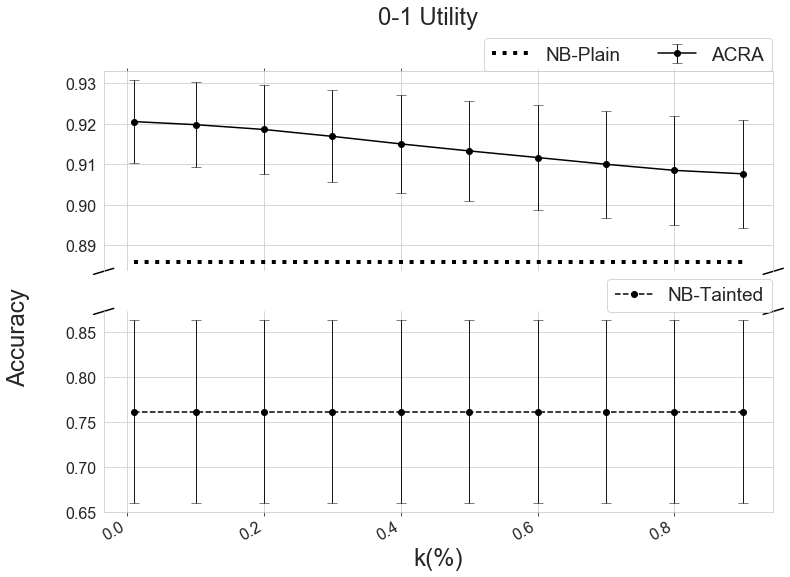

In [115]:
ut0 = means[means.Ut01 == 0.0]
ut0_dev = deviations[deviations.Ut01 == 0.0] 
p = scatterPlotTesting(ut0["var"],ut0["ACRA_Acc"], ut0["NBC_Acc"], ut0["NB_Acc"],\
                ut0_dev['ACRA_Acc'], ut0_dev["NB_Acc"], ["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Accuracy",\
               "0-1 Utility", "plots/prb/ign_accUt0.eps")
p.show()

In [16]:
def scatterPlot2(x,y1,y2,y3,l, xl, yl, t, name):
    f,(ax,ax2) = plt.subplots(2,1,sharex=True, facecolor='w')
    # Autoscale y axis and set format en float
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    sns.set_style("whitegrid")
    # plot the same data on both axes
    ax2.plot(x, y1, color = sns.xkcd_rgb["pale red"])
    ax2.plot(x, y2, color = sns.xkcd_rgb["denim blue"])
    ax.plot(x, y3, color = sns.xkcd_rgb["medium green"])

    ax2.legend(labels=[l[0], l[1]])
    ax.legend(labels=[l[2]])
    
    plt.gcf().autofmt_xdate()
    ax2.set(xlabel=xl)
    ax2.set_ylabel(yl)
    ax2.yaxis.set_label_coords(0.04, 0.47, transform=f.transFigure)

    f.suptitle(t) 


    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop='off')  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # This looks pretty good, and was fairly painless, but you can get that
    # cut-out diagonal lines look with just a bit more work. The important
    # thing to know here is that in axes coordinates, which are always
    # between 0-1, spine endpoints are at these locations (0,0), (0,1),
    # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
    # appropriate corners of each of our axes, and so long as we use the
    # right transform and disable clipping.

    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # What's cool about this is that now if we vary the distance between
    # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
    # the diagonal lines will move accordingly, and stay right at the tips
    # of the spines they are 'breaking'
    plt.savefig(name, format='eps', dpi=1000)

    return(plt)

In [92]:
def scatterPlotTesting2(x,y1,y2,y3,y1dev, y3dev, l, xl, yl, t,name):
    f,(ax,ax2) = plt.subplots(2,1,sharex=True, facecolor='w')
    # Set y axis numering format en float
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))    
    sns.set_style("whitegrid")
    # Plot the same data on both axes
    ax2.plot(x, y2, color = sns.xkcd_rgb["black"], linestyle=':', linewidth=4.0)
    ax2.errorbar(x, y1, yerr=y1dev ,ecolor='black', color = sns.xkcd_rgb["black"], fmt = 'o',  linestyle='-',elinewidth=0.9,capsize=5,capthick=0.5)
    ax.errorbar(x, y3, yerr=y3dev ,ecolor='black', color = sns.xkcd_rgb["black"], fmt = 'o', linestyle='--',elinewidth=0.9,capsize=5,capthick=0.5)
    
    # Pseudoescale (comment this part to not apply)
    #ax2.axis(ymin=min(y1-(2*y1dev)),ymax=max(1.5*y3+(y3dev))) # Testing
    #ax.axis(ymin=min(y1-(2*y1dev)),ymax=max(1.5*y3+(y3dev)))
    
    # Create box for legend
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Add legend and labels
    ax.legend(labels=[l[2]],loc='upper right', bbox_to_anchor=(0,1.02,1.011,0.2), prop={'size': 19})
    ax2.legend(labels=[l[1], l[0]],loc='upper right', bbox_to_anchor=(0,1.02,1.011,0.2), prop={'size': 19} ,ncol=2)
    ax2.set(xlabel=xl)
    ax2.set_ylabel(yl)
    ax2.yaxis.set_label_coords(0.04, 0.47, transform=f.transFigure)
    
    # Set size of title and x,y labels
    f.suptitle(t, fontsize=24)
    ax2.xaxis.label.set_size(24)
    ax2.yaxis.label.set_size(24)
    ax.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    
    # Hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop='off')  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    d = .015  # how big to make the diagonal lines in axes coordinates
    
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    plt.gcf().autofmt_xdate()
    plt.rcParams["figure.figsize"] = (12,9)
    plt.savefig(name, format='eps', dpi=1600)
    return(plt)

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


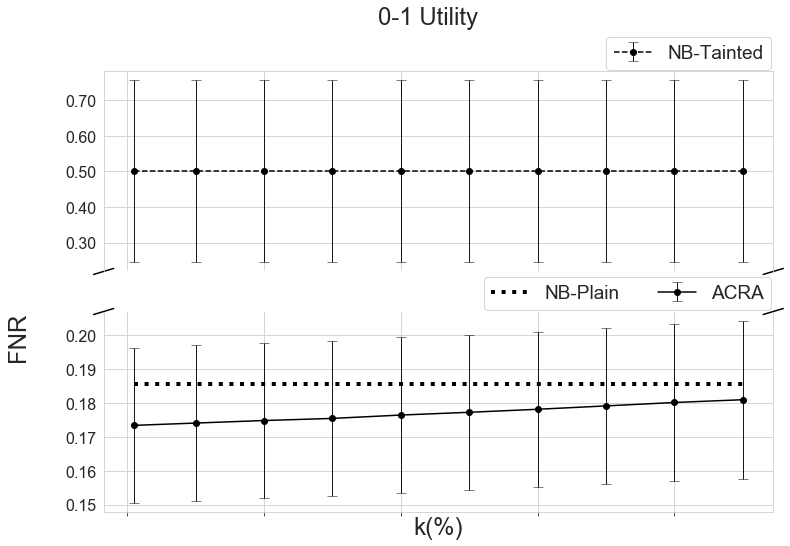

In [93]:
p = scatterPlotTesting2(ut0["var"],ut0["ACRA_FNR"],ut0["NBC_FNR"],ut0["NB_FNR"],\
                ut0_dev["ACRA_FNR"],ut0_dev["NB_FNR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FNR",\
               "0-1 Utility", "plots/prb/ign_fnut0.eps")
p.show()

In [19]:
def scatterPlot3(x,y1,y2,y3,l, xl, yl, t, name):
    f,ax2 = plt.subplots(1,1,sharex=True, facecolor='w')
    sns.set_style("whitegrid")
    # plot the same data on both axes
    ax2.plot(x, y1, color = sns.xkcd_rgb["pale red"])
    ax2.plot(x, y3, color = sns.xkcd_rgb["medium green"])
    ax2.plot(x, y2, color = sns.xkcd_rgb["denim blue"])
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    ax2.legend(labels=[l[0], l[2],l[1]],loc='upper right', bbox_to_anchor=(0,1.02,1,0.2), prop={'size': 14})
    plt.gcf().autofmt_xdate()
    ax2.set(xlabel=xl)
    ax2.set_ylabel(yl)
    #ax.yaxis.set_label_coords(0.04, 0.47, transform=fig.transFigure)
    f.suptitle(t)
    plt.savefig(name, format='eps', dpi=1000)
    return(plt)

In [98]:
def scatterPlotTesting3(x,y1,y2,y3,y1dev, y3dev,l,xl, yl, t,name):
    f,ax2 = plt.subplots(1,1,sharex=True, facecolor='w')
    sns.set_style("whitegrid")
    # Plot distributions
    ax2.plot(x, y2, color = sns.xkcd_rgb["black"], linestyle=':', linewidth=4.0)
    ax2.errorbar(x, y1, yerr=y1dev ,ecolor='black', color = sns.xkcd_rgb["black"], fmt = 'o',linestyle='-',elinewidth=0.9,capsize=5,capthick=0.5)
    ax2.errorbar(x, y3, yerr=y3dev ,ecolor='black', color = sns.xkcd_rgb["black"], fmt = 'o', linestyle='--',elinewidth=0.9,capsize=5,capthick=0.5)
    # Create the legend box
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Add legend and labels
    ax2.legend(labels=[l[1], l[0],l[2]],loc='upper right', bbox_to_anchor=(0,0.885,1.011,0.2), prop={'size': 17}, ncol=3)
    ax2.set(xlabel=xl)
    ax2.set_ylabel(yl)
    # Set size of title and x,y labels
    plt.gcf().autofmt_xdate()
    ax2.tick_params(labelsize=20)
    f.suptitle(t,x=0.5, fontsize=24)
    ax2.xaxis.label.set_size(24)
    ax2.yaxis.label.set_size(24)
    plt.rcParams["figure.figsize"] = (12,9)
    
    plt.savefig(name, format='eps', dpi=1600)
    # plt.savefig(name, format='svg', dpi=1200)
    return(plt)    

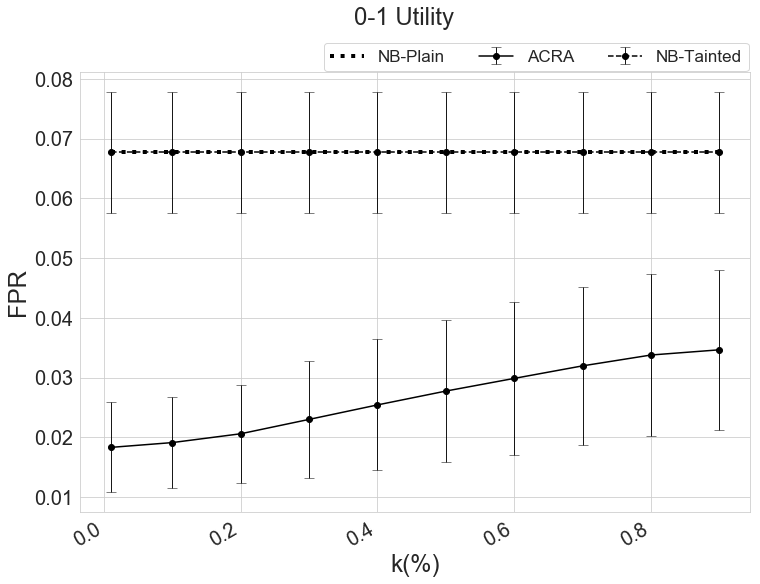

In [99]:
p = scatterPlotTesting3(ut0["var"],ut0["ACRA_FPR"],ut0["NBC_FPR"],ut0["NB_FPR"],\
             ut0_dev["ACRA_FPR"],ut0_dev["NB_FPR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FPR","0-1 Utility", \
                 "plots/lastExp/ign_fput0.eps")
p.show()

### Plot accuracies for different utilities

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


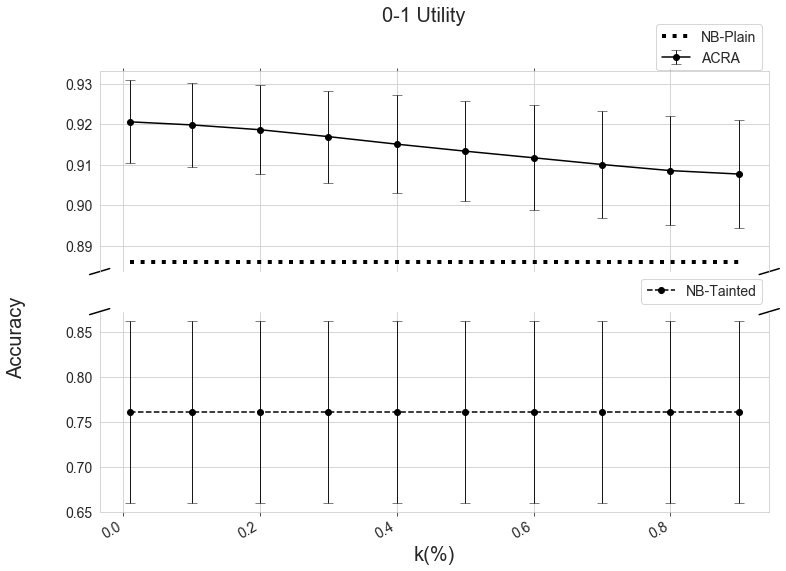

In [22]:
ut0 = means[means.Ut01 == 0.0]
ut0_dev = deviations[deviations.Ut01 == 0.0] 


p = scatterPlotTesting(ut0["var"],ut0["ACRA_Acc"], ut0["NBC_Acc"], ut0["NB_Acc"],\
                ut0_dev['ACRA_Acc'], ut0_dev["NB_Acc"], ["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Accuracy",\
               "0-1 Utility", "plots/prb/ign_accUt0.eps")

p.show()

In [23]:
deviations

,var,Ut01,NBC_Acc,ACRA_Acc,NB_Acc,NBC_AvgUt,ACRA_AvgUt,NB_AvgUt,NBC_FPR,ACRA_FPR,NB_FPR,NBC_FNR,ACRA_FNR,NB_FNR
0,0.01,-10.0,0.009485,0.011286,0.095584,0.062603,0.054725,0.191529,0.009420,0.007337,0.009420,0.020526,0.024946,0.242013
1,0.01,-5.0,0.009232,0.011191,0.098702,0.037344,0.034914,0.196657,0.009928,0.007310,0.009928,0.019184,0.024372,0.249560
2,0.01,-2.0,0.008941,0.010645,0.100375,0.021982,0.023838,0.200170,0.010255,0.007456,0.010255,0.018357,0.023329,0.254176
3,0.01,0.0,0.008943,0.010230,0.101089,0.008943,0.010230,0.101089,0.010133,0.007532,0.010133,0.018890,0.022774,0.255782
4,0.10,-10.0,0.009485,0.011860,0.095584,0.062603,0.058375,0.191529,0.009420,0.007777,0.009420,0.020526,0.025827,0.242013
5,0.10,-5.0,0.009232,0.011532,0.098702,0.037344,0.036875,0.196657,0.009928,0.007721,0.009928,0.019184,0.024534,0.249560
6,0.10,-2.0,0.008941,0.010990,0.100375,0.021982,0.024802,0.200170,0.010255,0.007784,0.010255,0.018357,0.023542,0.254176
7,0.10,0.0,0.008943,0.010458,0.101089,0.008943,0.010458,0.101089,0.010133,0.007669,0.010133,0.018890,0.022913,0.255782
8,0.20,-10.0,0.009485,0.012420,0.095584,0.062603,0.062239,0.191529,0.009420,0.008168,0.009420,0.020526,0.026138,0.242013
9,0.20,-5.0,0.009232,0.011875,0.098702,0.037344,0.038664,0.196657,0.009928,0.008039,0.009928,0.019184,0.024616,0.249560


/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


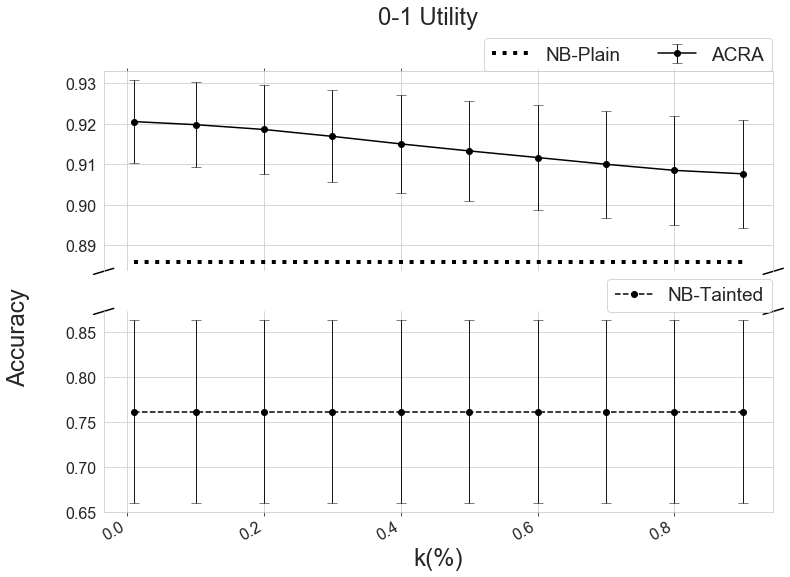

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


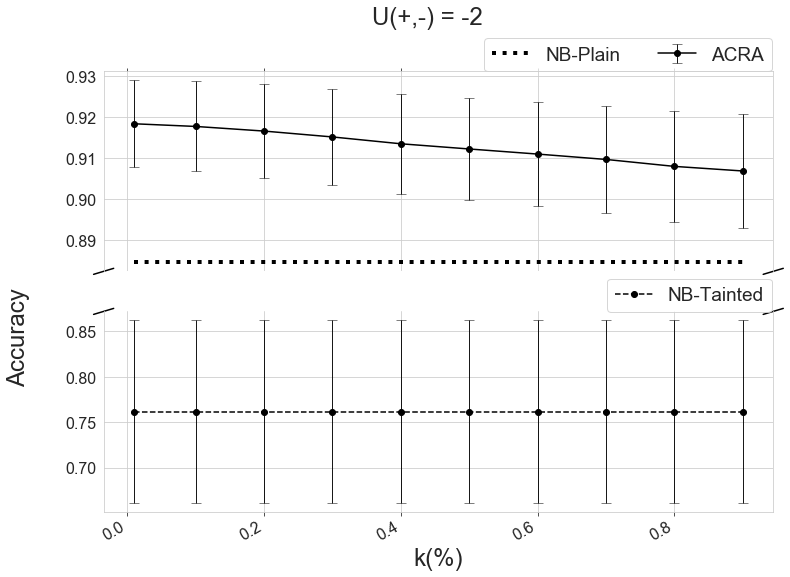

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


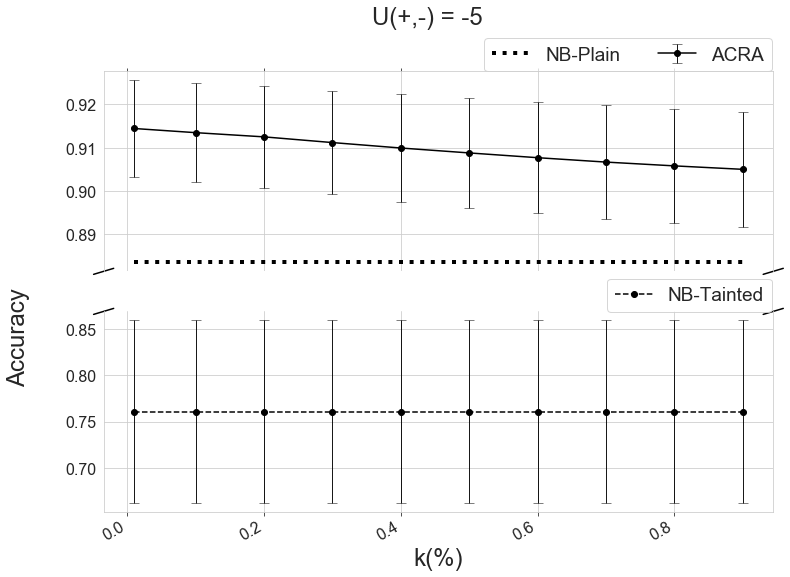

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


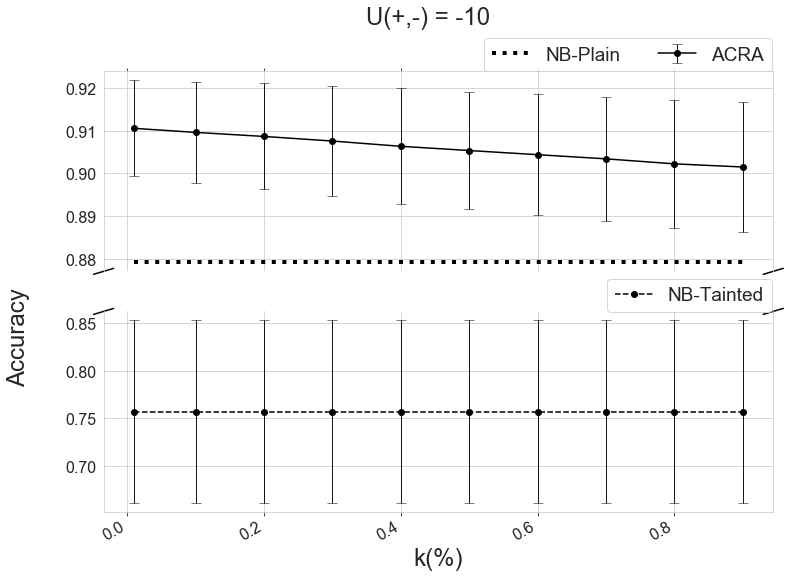

In [116]:
ut0 = means[means.Ut01 == 0.0]
ut0_dev = deviations[deviations.Ut01 == 0.0] 
p = scatterPlotTesting(ut0["var"],ut0["ACRA_Acc"], ut0["NBC_Acc"], ut0["NB_Acc"],\
                ut0_dev['ACRA_Acc'], ut0_dev["NB_Acc"], ["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Accuracy",\
               "0-1 Utility", "plots/PlotsNotScaleV3/ign_accUt0.eps")
p.show()
#########################################################################################
ut2 = means[means.Ut01 == -2.0]
ut2_dev = deviations[deviations.Ut01 == -2.0]
q = scatterPlotTesting(ut2["var"],ut2["ACRA_Acc"],ut2["NBC_Acc"],ut2["NB_Acc"],\
                ut2_dev['ACRA_Acc'], ut2_dev["NB_Acc"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Accuracy",\
               "U(+,-) = -2","plots/PlotsNotScaleV3/ign_accUt1.eps")
q.show()
#########################################################################################
ut5 = means[means.Ut01 == -5.0]
ut5_dev = deviations[deviations.Ut01 == -5.0]
r = scatterPlotTesting(ut5["var"],ut5["ACRA_Acc"],ut5["NBC_Acc"],ut5["NB_Acc"],\
                ut5_dev['ACRA_Acc'], ut5_dev["NB_Acc"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Accuracy",\
               "U(+,-) = -5", "plots/PlotsNotScaleV3/ign_accUt5.eps")
r.show()
#########################################################################################
ut10 = means[means.Ut01 == -10.0]
ut10_dev = deviations[deviations.Ut01 == -10.0]
s = scatterPlotTesting(ut10["var"],ut10["ACRA_Acc"],ut10["NBC_Acc"],ut10["NB_Acc"],\
                ut10_dev['ACRA_Acc'], ut10_dev["NB_Acc"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Accuracy",\
               "U(+,-) = -10", "plots/PlotsNotScaleV3/ign_accUt10.eps")
s.show()

### Plot average utility 

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


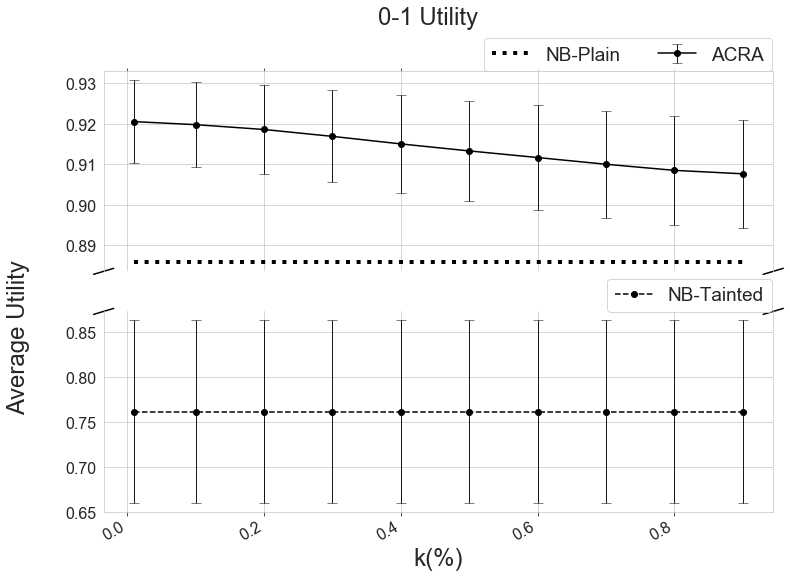

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


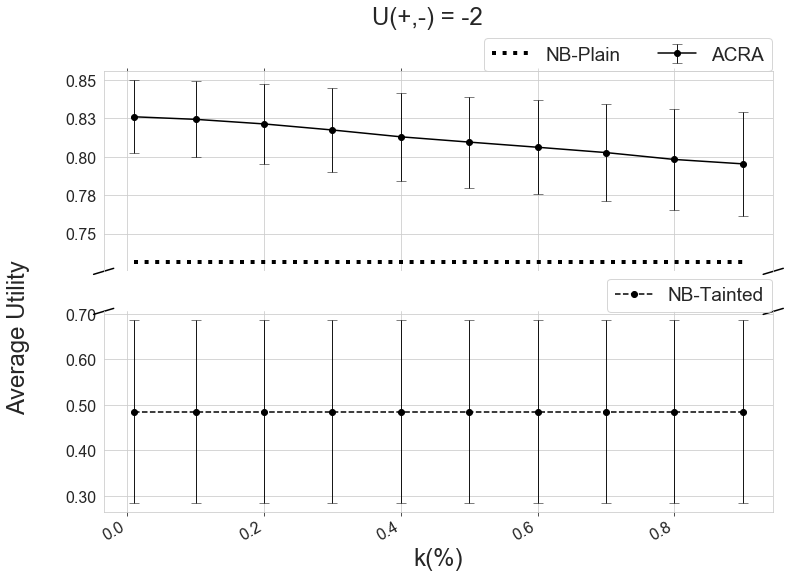

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


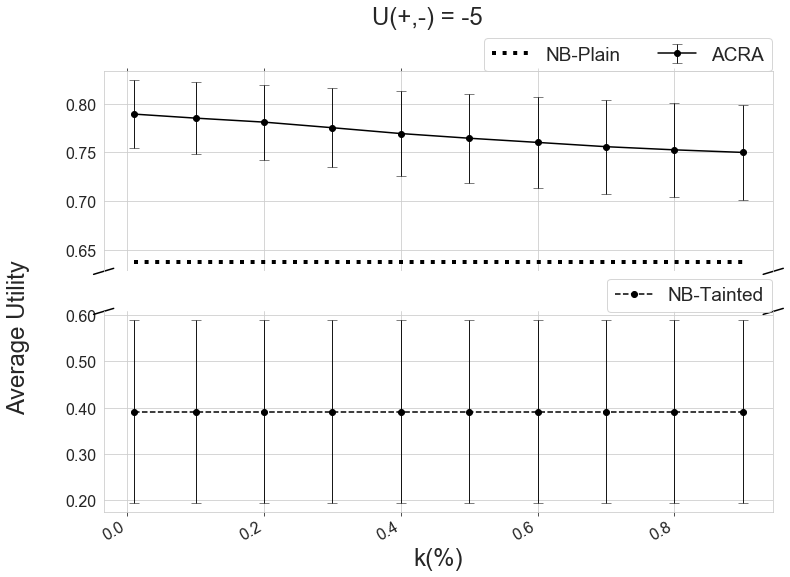

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


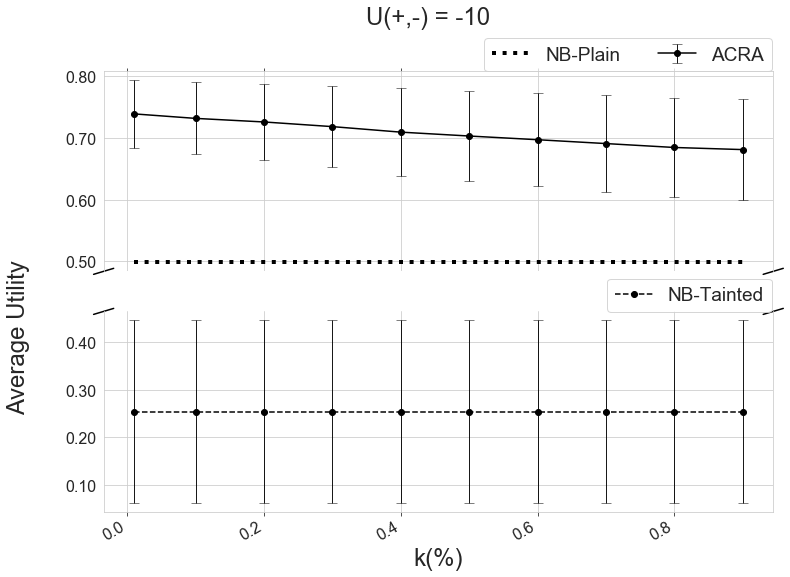

In [117]:
p = scatterPlotTesting(ut0["var"],ut0["ACRA_AvgUt"],ut0["NBC_AvgUt"],ut0["NB_AvgUt"],\
                ut0_dev['ACRA_AvgUt'], ut0_dev["NB_AvgUt"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Average Utility",\
               "0-1 Utility", "plots/PlotsNotScaleV3/ign_avut0.eps")
p.show()
#########################################################################################
q = scatterPlotTesting(ut2["var"],ut2["ACRA_AvgUt"],ut2["NBC_AvgUt"],ut2["NB_AvgUt"],\
                ut2_dev['ACRA_AvgUt'], ut2_dev["NB_AvgUt"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Average Utility",\
               "U(+,-) = -2", "plots/PlotsNotScaleV3/ign_avut1.eps")

q.show()
#########################################################################################
r = scatterPlotTesting(ut5["var"],ut5["ACRA_AvgUt"],ut5["NBC_AvgUt"],ut5["NB_AvgUt"],\
                ut5_dev['ACRA_AvgUt'], ut5_dev["NB_AvgUt"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Average Utility",\
               "U(+,-) = -5", "plots/PlotsNotScaleV3/ign_avut5.eps")
r.show()
#########################################################################################
s = scatterPlotTesting(ut10["var"],ut10["ACRA_AvgUt"],ut10["NBC_AvgUt"],ut10["NB_AvgUt"],\
                ut10_dev['ACRA_AvgUt'], ut10_dev["NB_AvgUt"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "Average Utility",\
               "U(+,-) = -10", "plots/PlotsNotScaleV3/ign_avut10.eps")
s.show()

### Plot FNR for different Utilities

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


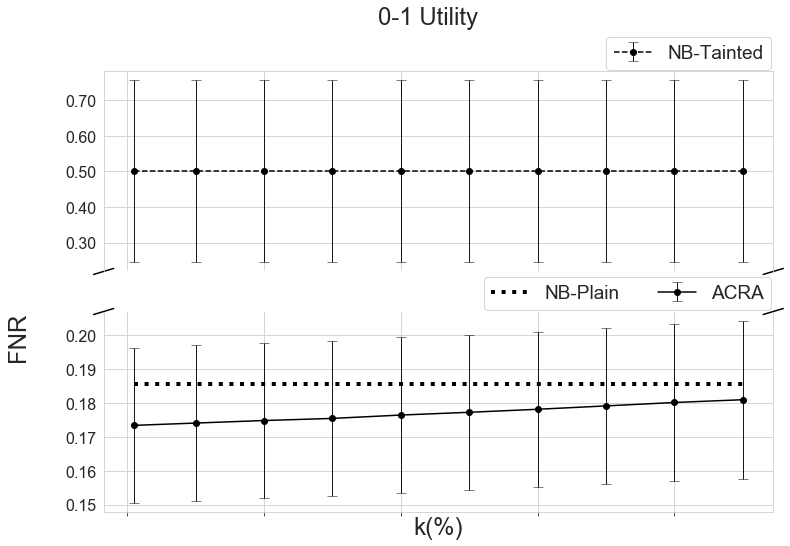

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


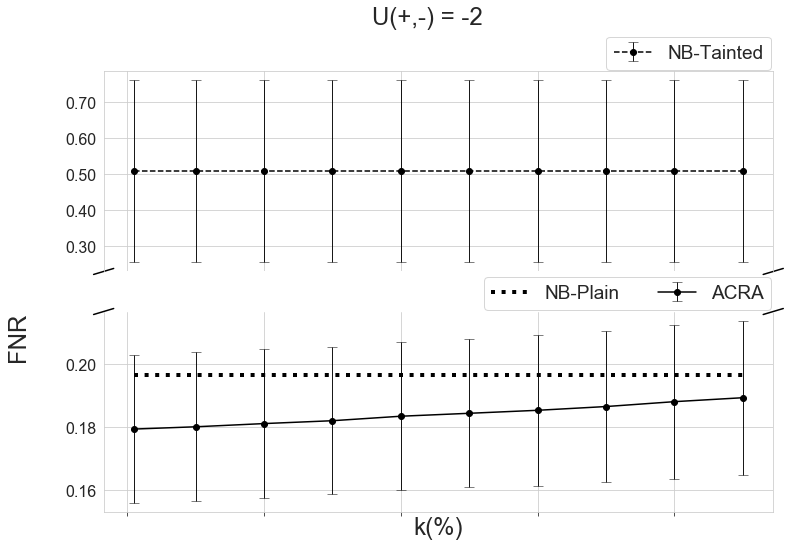

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


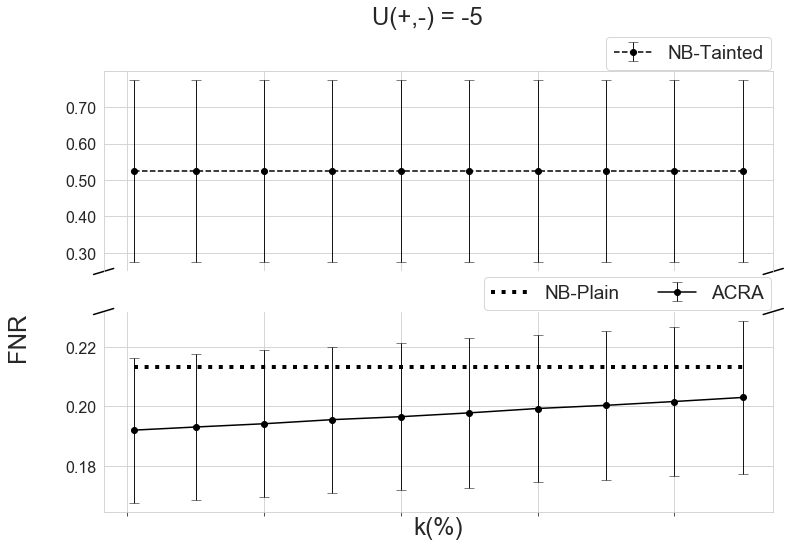

/Users/eagle/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


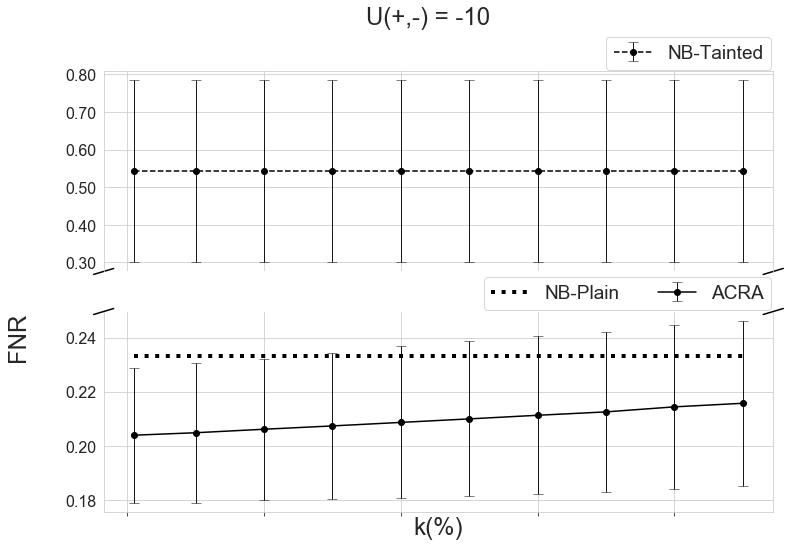

In [118]:
p = scatterPlotTesting2(ut0["var"],ut0["ACRA_FNR"],ut0["NBC_FNR"],ut0["NB_FNR"],\
                ut0_dev["ACRA_FNR"],ut0_dev["NB_FNR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FNR",\
               "0-1 Utility", "plots/PlotsNotScaleV3/ign_fnut0.eps")
p.show()
#########################################################################################
q = scatterPlotTesting2(ut2["var"],ut2["ACRA_FNR"],ut2["NBC_FNR"],ut2["NB_FNR"],\
                 ut2_dev["ACRA_FNR"],ut2_dev["NB_FNR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FNR",\
               "U(+,-) = -2", "plots/PlotsNotScaleV3/ign_fnut1.eps")
q.show()
#########################################################################################
r = scatterPlotTesting2(ut5["var"],ut5["ACRA_FNR"],ut5["NBC_FNR"],ut5["NB_FNR"],\
                 ut5_dev["ACRA_FNR"],ut5_dev["NB_FNR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FNR",\
               "U(+,-) = -5", "plots/PlotsNotScaleV3/ign_fnut5.eps")
r.show()
#########################################################################################
s = scatterPlotTesting2(ut10["var"],ut10["ACRA_FNR"],ut10["NBC_FNR"],ut10["NB_FNR"],\
                 ut10_dev["ACRA_FNR"],ut10_dev["NB_FNR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FNR",\
               "U(+,-) = -10", "plots/PlotsNotScaleV3/ign_fnut10.eps")
s.show()

### Plot FPR for different Utilities

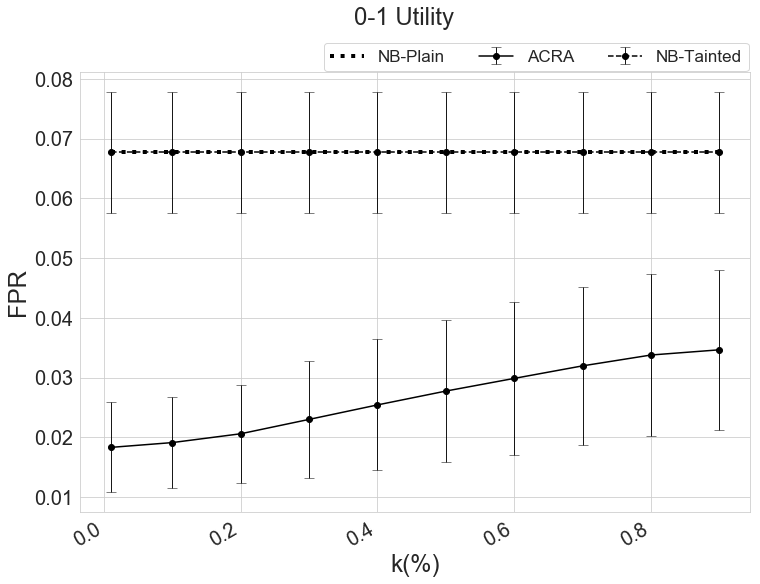

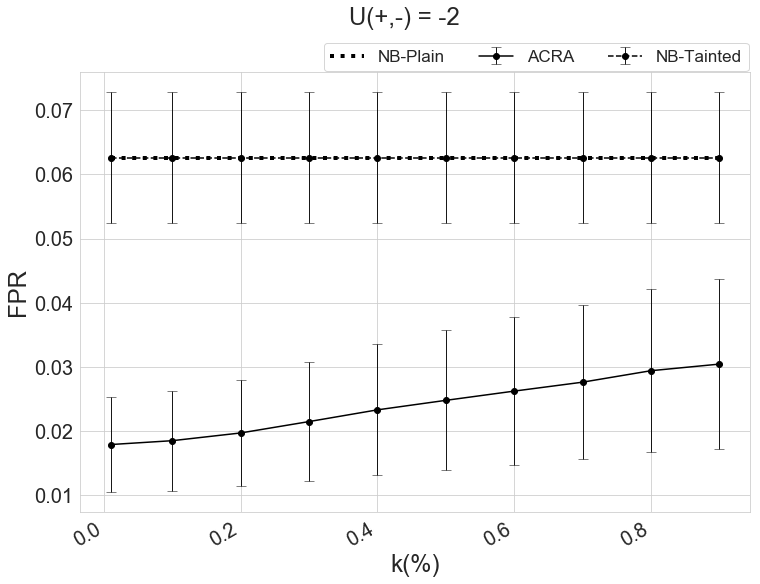

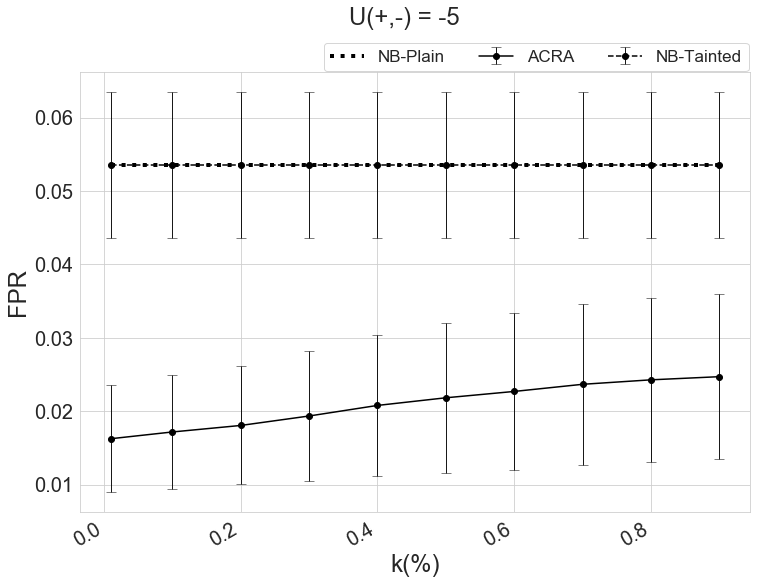

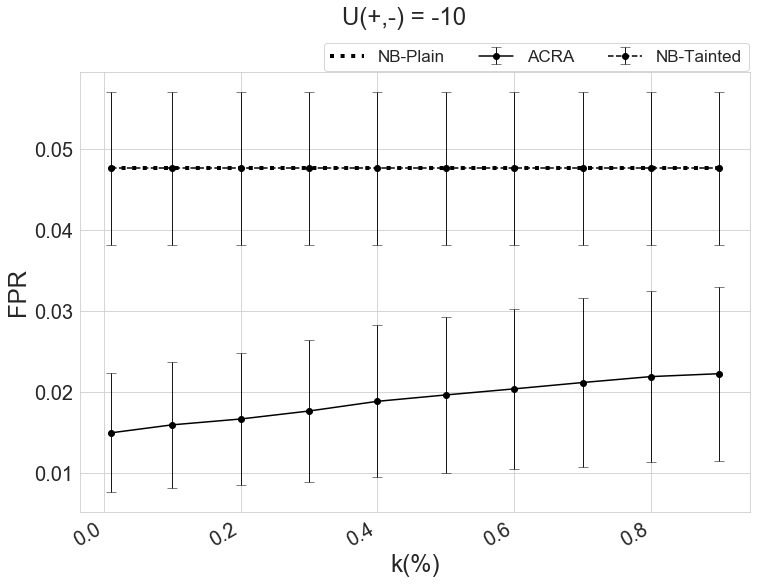

In [119]:
p = scatterPlotTesting3(ut0["var"],ut0["ACRA_FPR"],ut0["NBC_FPR"],ut0["NB_FPR"],\
             ut0_dev["ACRA_FPR"],ut0_dev["NB_FPR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FPR","0-1 Utility", \
                 "plots/PlotsNotScaleV3/ign_fput0.eps")
p.show()
#########################################################################################
q = scatterPlotTesting3(ut2["var"],ut2["ACRA_FPR"],ut2["NBC_FPR"],ut2["NB_FPR"], \
            ut2_dev["ACRA_FPR"],ut2_dev["NB_FPR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FPR","U(+,-) = -2", \
                 "plots/PlotsNotScaleV3/ign_fput1.eps")
q.show()
#########################################################################################
r = scatterPlotTesting3(ut5["var"],ut5["ACRA_FPR"],ut5["NBC_FPR"],ut5["NB_FPR"], \
            ut5_dev["ACRA_FPR"],ut5_dev["NB_FPR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FPR","U(+,-) = -5", \
                 "plots/PlotsNotScaleV3/ign_fput5.eps")
r.show()
#########################################################################################
s = scatterPlotTesting3(ut10["var"],ut10["ACRA_FPR"],ut10["NBC_FPR"],ut10["NB_FPR"], \
            ut10_dev["ACRA_FPR"],ut10_dev["NB_FPR"],["ACRA", "NB-Plain", "NB-Tainted"], "k(%)", "FPR","U(+,-) = -10", \
                 "plots/PlotsNotScaleV3/ign_fput10.eps")
s.show()